# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import sys, os
import time

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.drop('RegionID',axis=1,inplace=True)

In [4]:
df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

# Step 3: EDA and Visualization

In [6]:
font = {'family' : 'normal',
#'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


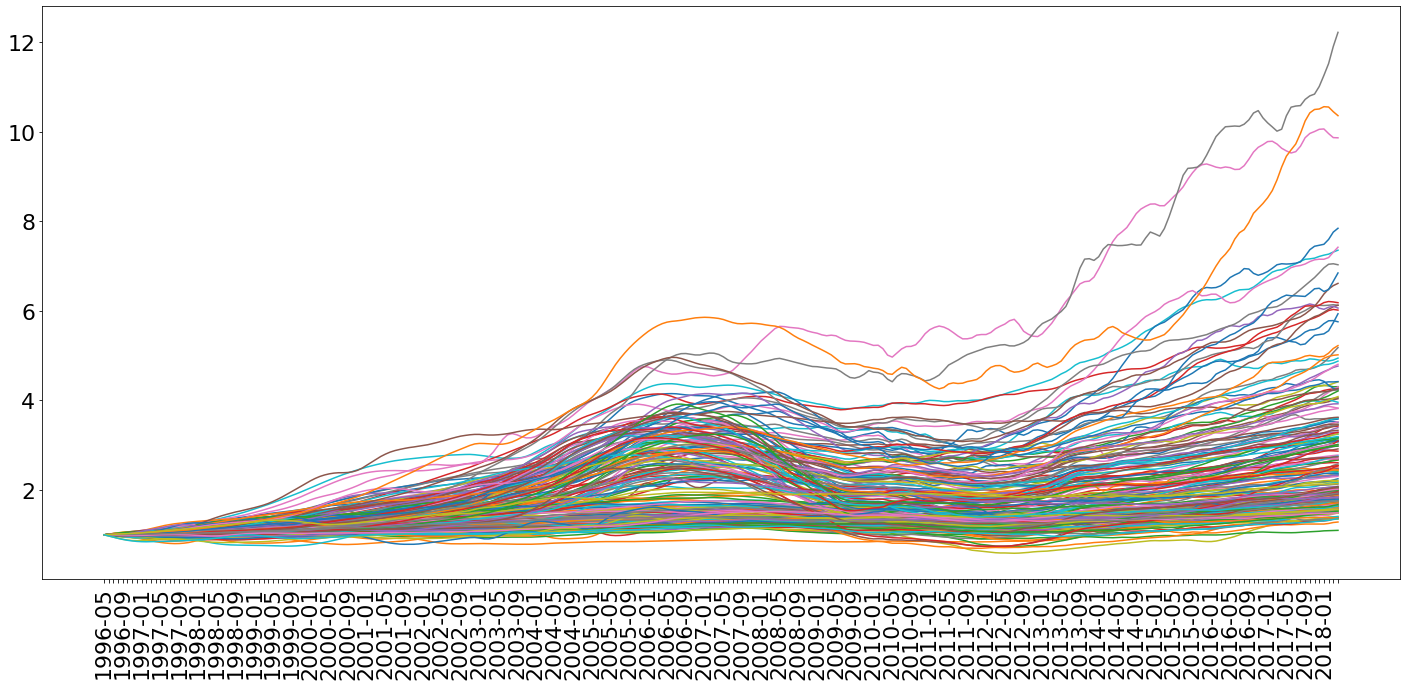

In [7]:
fig, ax = plt.subplots(figsize=(20,10))

plt.xticks(rotation='vertical')
for i in range(200):
    plt.plot(df.columns[7:],df.iloc[i][7:]/df.iloc[i][7])
    every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.tight_layout()
plt.savefig('Figures/roi_200.png')


#### Plotting roi distributions assuming different starting dates

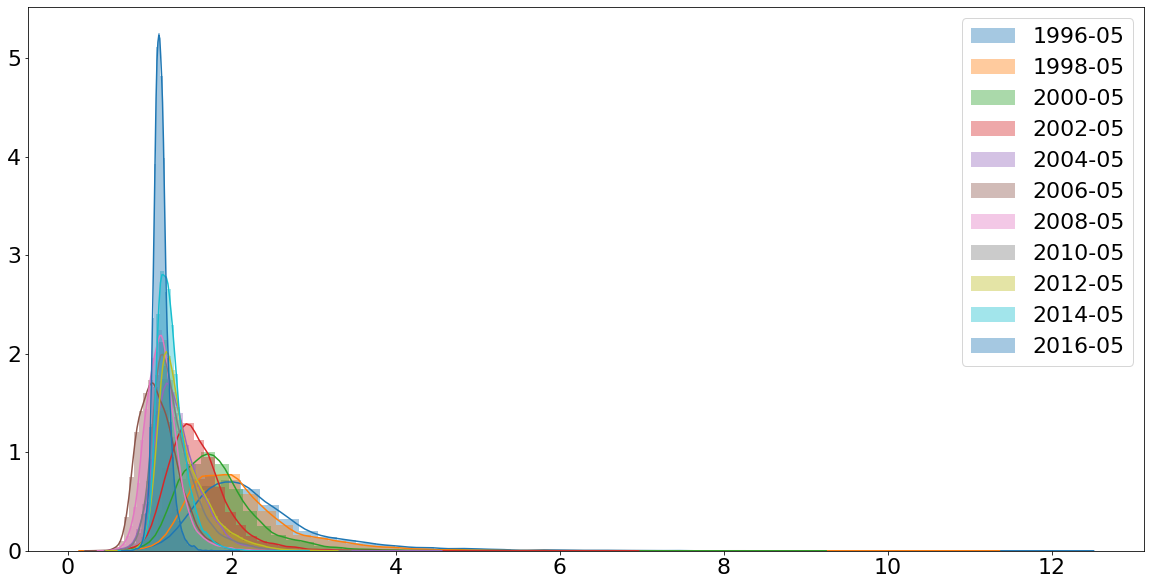

In [8]:
plt.figure(figsize=(20,10))
for i in range(7,df.shape[1]-1,24):
    roi = (df[df.columns[-1]]/df[df.columns[i]]).dropna()
    sns.distplot(roi,label = df.columns[i])
plt.legend()

# Step 4: Reshape from Wide to Long Format

In [9]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
#    print(melted.head())
#    print(melted.shape)
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
#    print(melted.shape)
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
average_ts = melt_data(df)

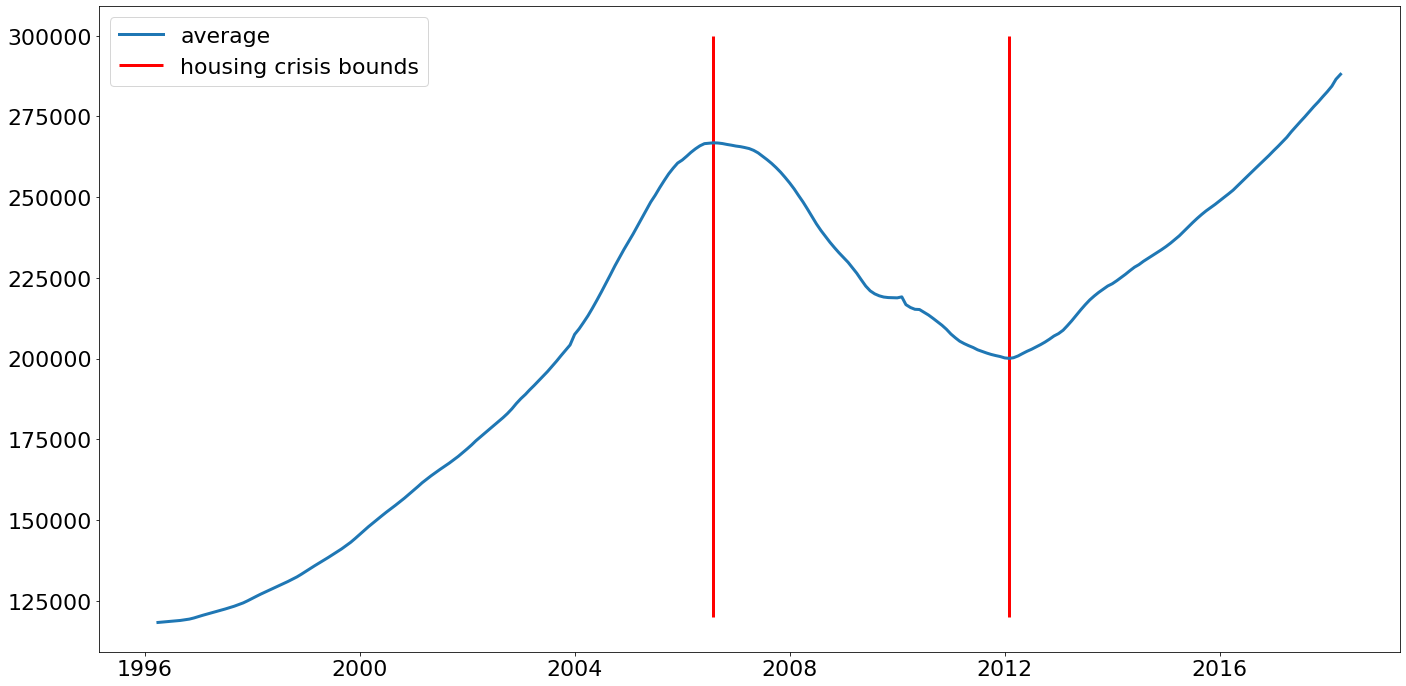

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(average_ts,label = 'average',linewidth=3);
plt.vlines('2006-08',ymin=120000,ymax=300000,label='housing crisis bounds',color='r',linewidth=3)
plt.vlines('2012-02',ymin=120000,ymax=300000,color='r',linewidth=3)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/average.png')

### Naive estimates

#### Calculating starting from April 1996

In [12]:
approx_roi_total = []
for i in range(df.shape[0]):
    prices = df.iloc[i][6:].dropna()
    approx_roi_total.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_total = df.copy()
df_roi_total['roi_monthly'] = approx_roi_total

df_roi_total = (df_roi_total.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]

#### Calculating starting from Feb 2012

In [13]:
approx_roi_2012 = []
for i in range(df.shape[0]):
    prices = df.iloc[i][196:].dropna()
    approx_roi_2012.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_2012 = df.copy()
df_roi_2012['roi_monthly'] = approx_roi_2012

df_roi_2012 = (df_roi_2012.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]

In [14]:
approx_roi_2012_nona = []
df_no_na = df.dropna()
for i in range(df_no_na.shape[0]):
    prices = df_no_na.iloc[i][196:].dropna()
    approx_roi_2012_nona.append(np.log(prices[-1]/prices[0])/len(prices))
df_roi_2012_nona = df_no_na.copy()
df_roi_2012_nona['roi_monthly'] = approx_roi_2012_nona

df_roi_2012_nona = (df_roi_2012_nona.sort_values(by='roi_monthly',ascending=False))[['RegionName','City','State','roi_monthly']]
df_roi_2012_nona.head()

,RegionName,City,State,roi_monthly
1853,94804,Richmond,CA,0.015304
474,85008,Phoenix,AZ,0.015298
1477,94601,Oakland,CA,0.015188
1239,94590,Vallejo,CA,0.015110
2627,33460,Lake Worth,FL,0.015037


# Step 5: ARIMA Modeling

## Let's first perform the ARIMA modelling on the average data set to see what insights we can glean

### We need to make the data set weakly stationary. First let's detrend the dataset

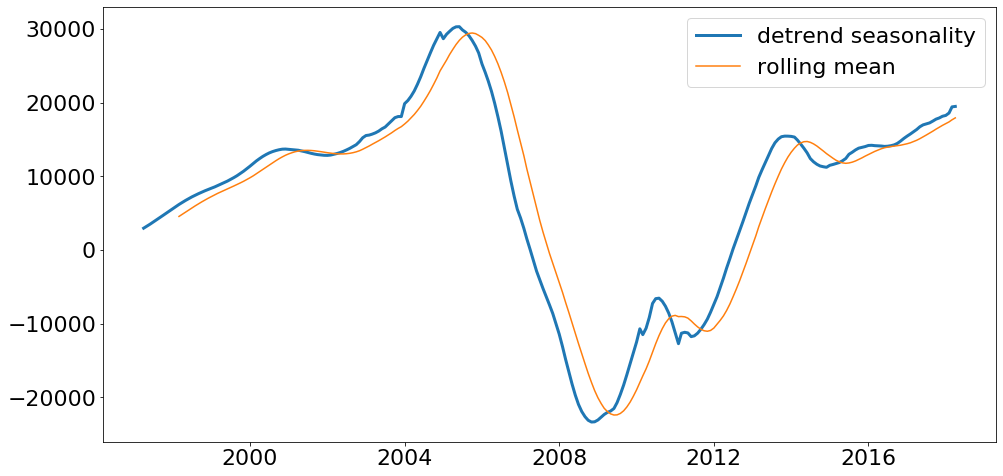

In [30]:
average_diff = average_ts.diff(12)
plt.figure(figsize=(16,8))
plt.plot(average_diff,linewidth=3,label='detrend seasonality')
plt.plot(average_diff.rolling(window=12).mean(),label='rolling mean')
plt.legend()
#plt.hlines(0,xmin='1997-01',xmax='2018-04')
#plt.vlines('2007-03',ymin=-30000,ymax=32000)

In [547]:
average_test = ((average_ts.diff(1).shift(-1)/average_ts)[-73:-1])
results = pm.auto_arima(average_test,information_criterion='aic',m=12,d=0,start_p=1,start_q=1, max_p=3, max_q=3,
stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
mod = sm.tsa.statespace.SARIMAX(average_test.loc['2013-01-01':'2018-04-01'],order=results.order,
                                                seasonal_order=results.seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
output = mod.fit()
pred = output.get_prediction(start=pd.to_datetime('2018-03-01'),end = pd.to_datetime('2020-05-01'), dynamic=False)
pred_conf = pred.conf_int()
    #rcParams['figure.figsize'] = 15, 6
mean_ret = np.prod(1+pred.predicted_mean)
low_ret = np.prod(1+pred_conf.iloc[:,0])
high_ret = np.prod(1+pred_conf.iloc[:,1])
risk_free_mean = mean_ret

#### Differencing with order 2 and 3 to check stationarity

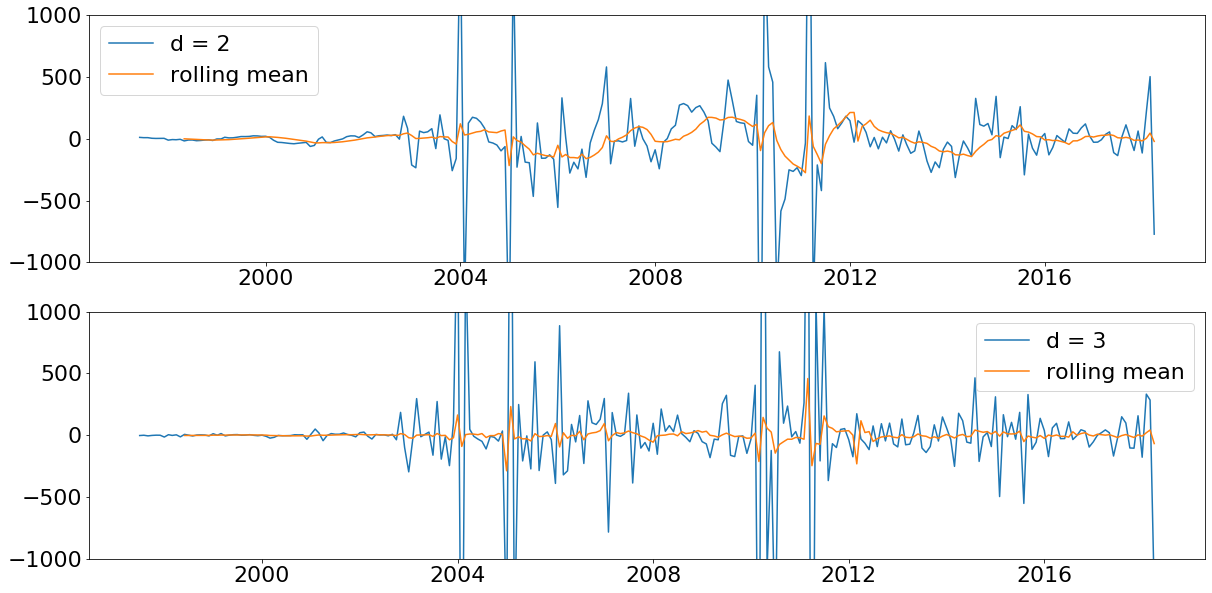

In [50]:
#average_diff_1 = average_diff.diff()
fig, ax = plt.subplots(2,1,figsize=(20,10))
average_diff_2 = average_diff-2*average_diff.shift()+average_diff.shift(2)
average_diff_3 = average_diff -3*average_diff.shift()+3*average_diff.shift(2)-average_diff.shift(3)
#plt.plot(average_diff_1,label='d = 1')
ax[0].plot(average_diff_2,label='d = 2')
ax[0].plot(average_diff_2.rolling(window=12).mean(),label='rolling mean')
ax[0].set_ylim([-1000,1000])
#plt.plot(average_diff_3,label='d = 3')
ax[0].legend()
ax[1].plot(average_diff_3,label='d = 3')
ax[1].plot(average_diff_3.rolling(window=12).mean(),label='rolling mean')
ax[1].set_ylim([-1000,1000])
#plt.plot(average_diff_3,label='d = 3')
ax[1].legend()

#### d=3 looks reasonably stationary Now let's do an ARIMA analysis  on prices starting from 2013

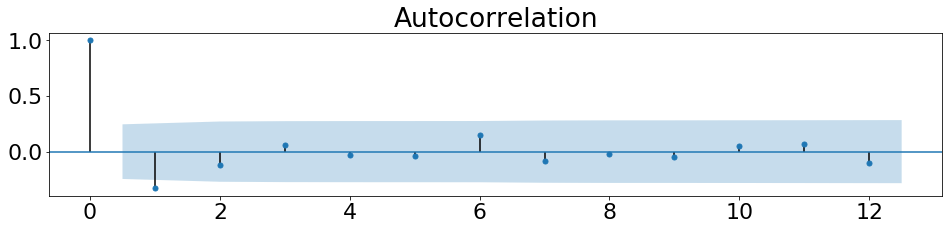

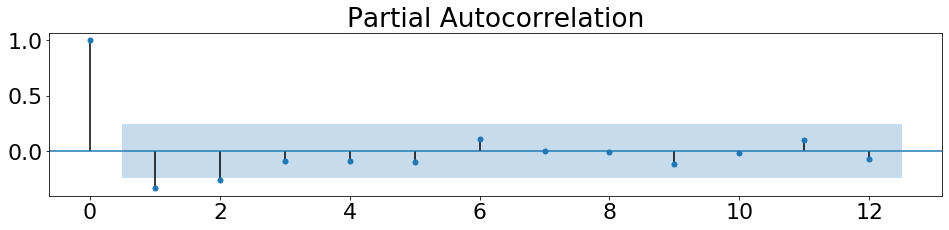

In [86]:
average_last5 = average_diff_3.loc['2013-01-01':'2018-04-01']
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(average_last5,ax=ax, lags=12);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(average_last5,ax=ax, lags=12);

In [168]:
# assuming your time series are stored in an object "series"
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an AR(1) model to the first simulated data
mod_arma = ARMA(average_last5, order=(0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   64
Model:                     ARMA(0, 1)   Log Likelihood                -421.587
Method:                       css-mle   S.D. of innovations            169.991
Date:                Fri, 31 Jan 2020   AIC                            849.174
Time:                        19:26:48   BIC                            855.650
Sample:                    01-01-2013   HQIC                           851.725
                         - 04-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2339      1.124      1.098      0.276      -0.969       3.437
ma.L1.value    -1.0000      0.058    -17.316      0.000      -1.113      -0.887
                                    Roots       

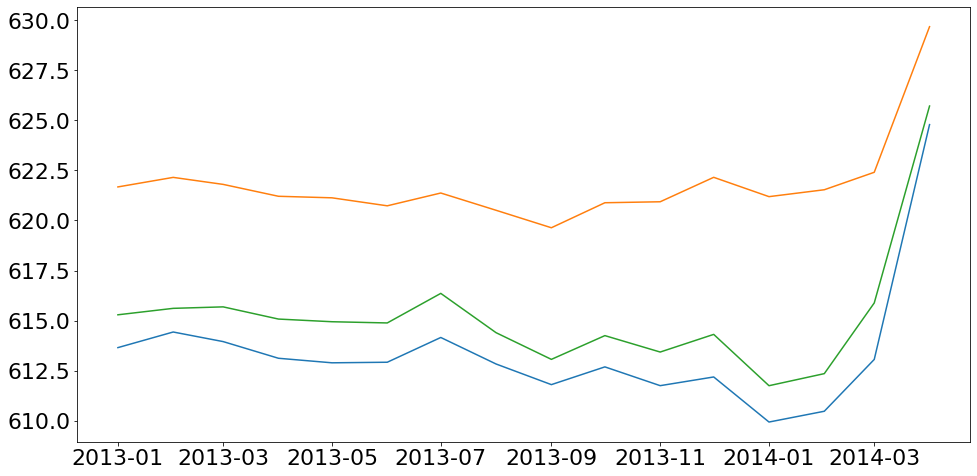

In [171]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
#plt.setp(ax[0].xaxis.get_majorticklabels,rotation=90)
#ax[0].set_xticklabels(dates,rotation=90)
window = 48
ma1 = []
orders = [(0,1),(1,0),(1,1)]
aic = np.zeros([len(average_last5)-window,len(orders)])
for i,w in enumerate(range(len(average_last5)-window)):
    for j,o in enumerate(orders):
#        print(w,o)
        mod_arma = ARMA(average_last5[w:w+window], order=o)
        res_arma = mod_arma.fit()
#        ma1.append(res_arma.params[1])
        aic[i,j] = res_arma.aic
dates = average_last5.index[0:len(average_last5)-window]
#ax[0].plot(dates,ma1)
ax.plot(dates,aic[:,0])
ax.plot(dates,aic[:,1])
ax.plot(dates,aic[:,2])

In [522]:
def melt_data_1(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
#    print(melted.head())
#    print(melted.shape)
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
#    print(melted.shape)
    return melted

def blockPrint():
    sys.stdout = open(os.devnull, 'w')
def enablePrint():
    sys.stdout = sys.__stdout__

In [244]:
melted_df = melt_data_1(df.dropna())

In [335]:
list_arma = [(0,1),(1,1),(1,0),(2,0),(0,2),(2,1),(1,2),(2,2)]
zipcodes = []
ma = []
aic = []
for i in df.dropna().RegionName[0:50]:
    df_city = melted_df[melted_df.RegionName==i][['time','value']]
    df_city.set_index('time',inplace=True)
    df_city = df_city.diff(12)

    df_city_3 = df_city -3*df_city.shift()+3*df_city.shift(2)-df_city.shift(3)
#    df_city_2 = df_city -2*df_city.shift()+df_city.shift(2)
#    plt.plot(df_city_3)
    df_city_last5 = df_city_3.loc['2013-01-01':'2018-04-01']
#    fig, ax = plt.subplots(figsize=(16,3))
#    plot_acf(df_city_last5,ax=ax, lags=12);

#    fig, ax = plt.subplots(figsize=(16,3))
#    plot_pacf(df_city_last5,ax=ax, lags=12);

    # Fit an AR(1) model to the first simulated data
#    print(i)
    list_aic = []
    for o in list_arma:
        try:
            mod_arma = ARMA(df_city_last5,order = o)
            res_arma = mod_arma.fit()
            #ma.append(res_arma.params[1])
            list_aic.append(res_arma.aic)
        except:
            list_aic.append(10000)
            continue
#    print(list_aic)
    zipcodes.append(i)
    aic.append([i,list_arma[np.nanargmin(list_aic)],np.nanmin(list_aic)])

In [424]:
df_city = melted_df[melted_df.RegionName==melted_df.RegionName[213]][['time','value']]

df_city.set_index('time',inplace=True)

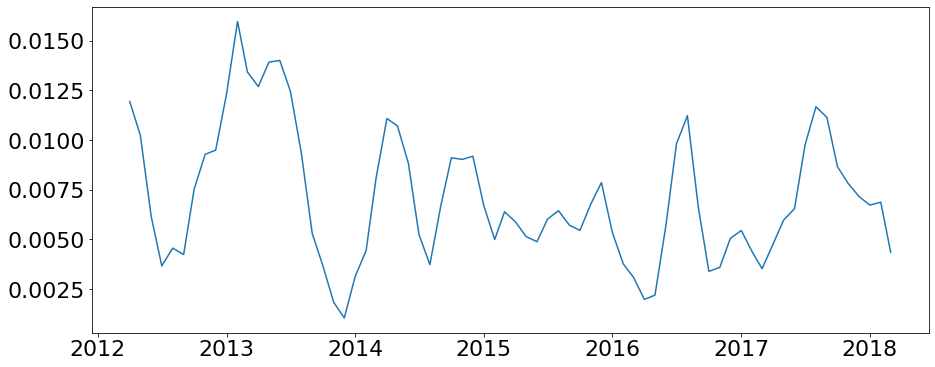

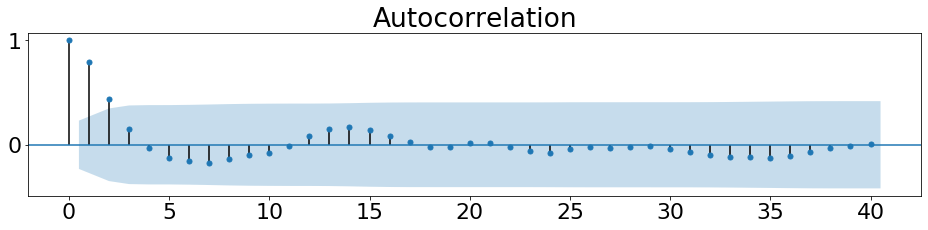

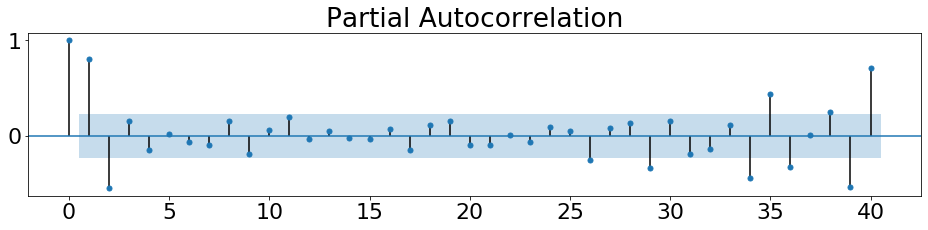

In [428]:
test = ((df_city.diff(1).shift(-1)/df_city)[-73:-1])
plt.plot(test)
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(test.dropna(),ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(test.dropna(),ax=ax, lags=40);

In [459]:
import pmdarima as pm
results = pm.auto_arima(test,information_criterion='aic',m=12,d=0,
 start_p=1,start_q=1, max_p=3, max_q=3,
 stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-679.419, BIC=-665.759, Fit time=0.482 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-614.511, BIC=-609.957, Fit time=0.062 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-657.344, BIC=-648.237, Fit time=0.432 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-662.070, BIC=-652.963, Fit time=0.285 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-491.975, BIC=-489.699, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-701.868, BIC=-690.485, Fit time=0.264 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-716.084, BIC=-706.977, Fit time=0.193 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-715.411, BIC=-704.028, Fit time=0.498 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-681.705, BIC=-674.875, Fit time=0.118 seconds
Fit ARIMA: order=(1, 0, 0) s

In [456]:
results.order

ARIMA(maxiter=50, method='bfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [465]:
blockPrint()
best_fit = []
for i in df.dropna().RegionName[0:10]:
    df_city = melted_df[melted_df.RegionName==i][['time','value']]
    df_city.set_index('time',inplace=True)
    test = ((df_city.diff(1).shift(-1)/df_city)[-73:-1])
    results = pm.auto_arima(test,information_criterion='aic',m=12,d=0,start_p=1,start_q=1, max_p=3, max_q=3,
     stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
    best_fit.append([i,results.order,results.seasonal_order])
enablePrint()

In [523]:
enablePrint()

In [524]:
print('a')

In [ ]:
start_time = time.time()
final_results_1000 = []
for i in df.dropna().RegionName[0:1000]:
    df_city = melted_df[melted_df.RegionName==i][['time','value']]
    df_city.set_index('time',inplace=True)
    test = ((df_city.diff(1).shift(-1)/df_city)[-73:-1])
    results = pm.auto_arima(test,information_criterion='aic',m=12,d=0,start_p=1,start_q=1, max_p=3, max_q=3,
    stepwise=True,trace=True,error_action='ignore',suppress_warnings=True,method='lbfgs')
    mod = sm.tsa.statespace.SARIMAX(test.loc['2013-01-01':'2018-04-01'],order=results.order,
                                                seasonal_order=results.seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
    output = mod.fit()
    pred = output.get_prediction(start=pd.to_datetime('2018-03-01'),end = pd.to_datetime('2020-05-01'), dynamic=False)
    pred_conf = pred.conf_int()
    #rcParams['figure.figsize'] = 15, 6
    mean_ret = np.prod(1+pred.predicted_mean)
    low_ret = np.prod(1+pred_conf.iloc[:,0])
    high_ret = np.prod(1+pred_conf.iloc[:,1])
    # Plot observed values
    #ax = test.loc['2013-01-01':'2018-04-01'].plot(label='observed')

    # Plot predicted values
    #pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    #ax.fill_between(pred_conf.index,
                    #pred_conf.iloc[:, 0],
                    #pred_conf.iloc[:, 1], 
                    #color='g', alpha=0.3)
    final_results_1000.append([i,mean_ret,low_ret,high_ret,results.order,results.seasonal_order])
time.time()-start_time

In [508]:
final = pd.DataFrame(final_results_1000,columns = ['zip','mean_ret','low_ret','high_ret','order','seasonal_order'])

In [541]:
final.sort_values(['mean_ret'],ascending=False).head(20)

,zip,mean_ret,low_ret,high_ret,order,seasonal_order
536,76179,7.223850e+221,-3.864830e+227,1.261025e+228,"(2, 0, 1)","(0, 0, 0, 12)"
657,96797,1.349923e+26,5.052983e+47,2.741577e+50,"(2, 0, 1)","(0, 0, 1, 12)"
758,20774,4.747114e+00,-1.415788e+12,3.539152e+17,"(2, 0, 1)","(0, 0, 1, 12)"
273,19124,1.910698e+00,1.309763e+00,2.772582e+00,"(1, 0, 3)","(1, 0, 0, 12)"
646,7306,1.823673e+00,1.060153e+00,3.103114e+00,"(0, 0, 2)","(2, 0, 1, 12)"
279,75150,1.567375e+00,1.058537e+00,2.307508e+00,"(1, 0, 1)","(2, 0, 0, 12)"
549,34668,1.530469e+00,9.352521e-01,2.481380e+00,"(1, 0, 3)","(0, 0, 0, 12)"
654,34698,1.496086e+00,1.084699e+00,2.055136e+00,"(3, 0, 0)","(2, 0, 1, 12)"
744,98125,1.460707e+00,1.105640e+00,1.924084e+00,"(0, 0, 2)","(2, 0, 0, 12)"
503,94087,1.457727e+00,6.538878e-01,3.169056e+00,"(2, 0, 2)","(2, 0, 0, 12)"


In [564]:
final = final[(final.mean_ret < 2.00) & (final.mean_ret > 0)]

In [565]:
final['sharpe_ratio'] = (final.mean_ret -risk_free_mean)/(final.high_ret - final.low_ret)

In [566]:
final.sort_values(['sharpe_ratio'],ascending=False)

,zip,mean_ret,low_ret,high_ret,order,seasonal_order,sharpe_ratio
166,27610,1.327700,1.164337,1.513015,"(1, 0, 3)","(0, 0, 0, 12)",0.524884
273,19124,1.910698,1.309763,2.772582,"(1, 0, 3)","(1, 0, 0, 12)",0.523656
744,98125,1.460707,1.105640,1.924084,"(0, 0, 2)","(2, 0, 0, 12)",0.386125
654,34698,1.496086,1.084699,2.055136,"(3, 0, 0)","(2, 0, 1, 12)",0.362106
382,28216,1.361971,1.089583,1.699270,"(2, 0, 2)","(1, 0, 0, 12)",0.356388
...,...,...,...,...,...,...,...
643,22030,1.007420,0.890753,1.138719,"(1, 0, 1)","(0, 0, 1, 12)",-0.553566
842,19335,0.998646,0.876331,1.137305,"(0, 0, 3)","(0, 0, 0, 12)",-0.559594
955,76542,0.996635,0.877949,1.130689,"(0, 0, 3)","(0, 0, 0, 12)",-0.585778
172,79938,1.001037,0.890198,1.125099,"(2, 0, 0)","(0, 0, 0, 12)",-0.611524


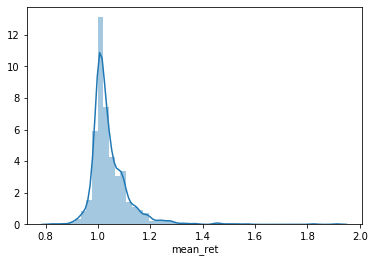

In [568]:
sns.distplot(final['mean_ret'])

In [375]:
p = d = q = range(0,3)
d = [3]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
#    for combs in [(0,3,0,12)]:
        try:
            df_zip = melted_df[melted_df.RegionName==melted_df.RegionName[57]][['time','value']]
#            df_zip = df_zip.diff(12)
            df_zip.set_index('time',inplace=True)
#            print(df_zip.loc['2013-01-01':'2018-04-01'])
            mod = sm.tsa.statespace.SARIMAX(df_zip.loc['2013-01-01':'2018-04-01'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={} BIC Calculated ={}'.format(comb, combs, output.aic,output.bic))
        except:
            print('except')
            continue

ARIMA (0, 3, 0) x (0, 3, 0, 12)12 : AIC Calculated =726.7718505639718 BIC Calculated =727.9499043943198
ARIMA (0, 3, 1) x (0, 3, 0, 12)12 : AIC Calculated =669.3424097603339 BIC Calculated =671.6133981921922
ARIMA (0, 3, 2) x (0, 3, 0, 12)12 : AIC Calculated =620.1768933201747 BIC Calculated =623.4500206802496
ARIMA (1, 3, 0) x (0, 3, 0, 12)12 : AIC Calculated =696.3783967091929 BIC Calculated =698.7345043698888
ARIMA (1, 3, 1) x (0, 3, 0, 12)12 : AIC Calculated =667.5802010922605 BIC Calculated =670.986683740048
ARIMA (1, 3, 2) x (0, 3, 0, 12)12 : AIC Calculated =617.3309531819294 BIC Calculated =621.6951229953627
ARIMA (2, 3, 0) x (0, 3, 0, 12)12 : AIC Calculated =632.7002141163449 BIC Calculated =636.1066967641324
ARIMA (2, 3, 1) x (0, 3, 0, 12)12 : AIC Calculated =625.7939418177361 BIC Calculated =630.3359186814528
ARIMA (2, 3, 2) x (0, 3, 0, 12)12 : AIC Calculated =627.5047903248153 BIC Calculated =632.9600025916069


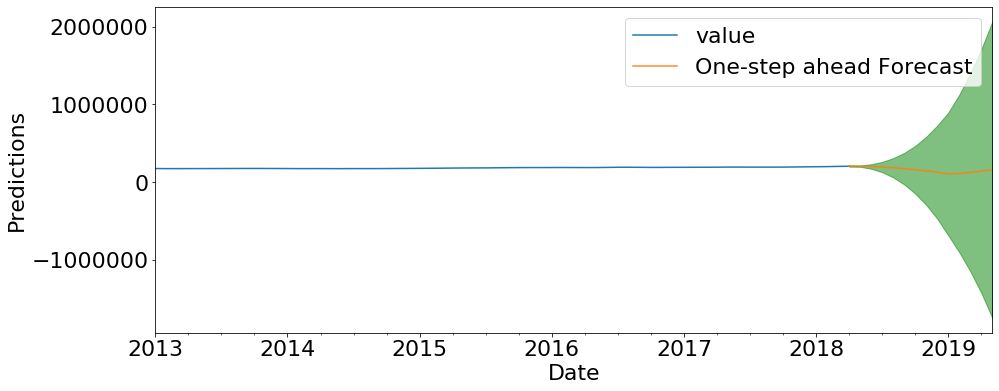

In [369]:
# Plot real vs predicted values along with confidence interval
mod = sm.tsa.statespace.SARIMAX(df_zip.loc['2013-01-01':'2018-04-01'],
                                            order=(1,3,0),
                                            seasonal_order=(1,3,0,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

output = mod.fit()
pred = output.get_prediction(start=pd.to_datetime('2018-04-01'),end = pd.to_datetime('2019-05-01'), dynamic=False)
pred_conf = pred.conf_int()
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_zip.loc['2013-01-01':'2018-04-01'].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], 
                color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Predictions')
plt.legend()

plt.show()


In [358]:
pred_conf.iloc[:, 1]

2017-04-01    989200.00037
Freq: MS, Name: upper value, dtype: float64

In [80]:
p = d = q = range(1,3)
d = range(2,4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(average_ts.iloc[0:72],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={} BIC Calculated ={}'.format(comb, combs, output.aic,output.bic))
        except:
            continue

ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =1364.482795892815 BIC Calculated =1371.8114754068135
ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =825.203609637812 BIC Calculated =831.4707442641525
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =1448.070948407907 BIC Calculated =1456.674871634818
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =911.1608595103024 BIC Calculated =918.4725165743664
ARIMA (1, 3, 1) x (1, 2, 1, 12)12 : AIC Calculated =260.4049798615787 BIC Calculated =267.57491588400444
ARIMA (1, 3, 1) x (2, 2, 1, 12)12 : AIC Calculated =177.82163128720865 BIC Calculated =183.7960249285326
ARIMA (1, 3, 2) x (1, 2, 1, 12)12 : AIC Calculated =253.85845206060685 BIC Calculated =262.26563635057977
ARIMA (1, 3, 2) x (2, 2, 1, 12)12 : AIC Calculated =177.70727971561624 BIC Calculated =184.67740563049418
ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =1214.4055928210848 BIC Calculated =1223.2000082378831
ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =694.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0958      0.791      0.121      0.904      -1.455       1.647
ar.L2         -0.5126      0.456     -1.123      0.261      -1.407       0.382
ma.L1          0.3327      0.478      0.696      0.487      -0.605       1.270
ar.S.L12      -0.4069      0.424     -0.959      0.338      -1.239       0.425
ar.S.L24       0.1364      0.152      0.895      0.371      -0.162       0.435
ma.S.L12      -0.3298      1.044     -0.316      0.752      -2.376       1.717
sigma2       174.9843    108.184      1.617      0.106     -37.053     387.022


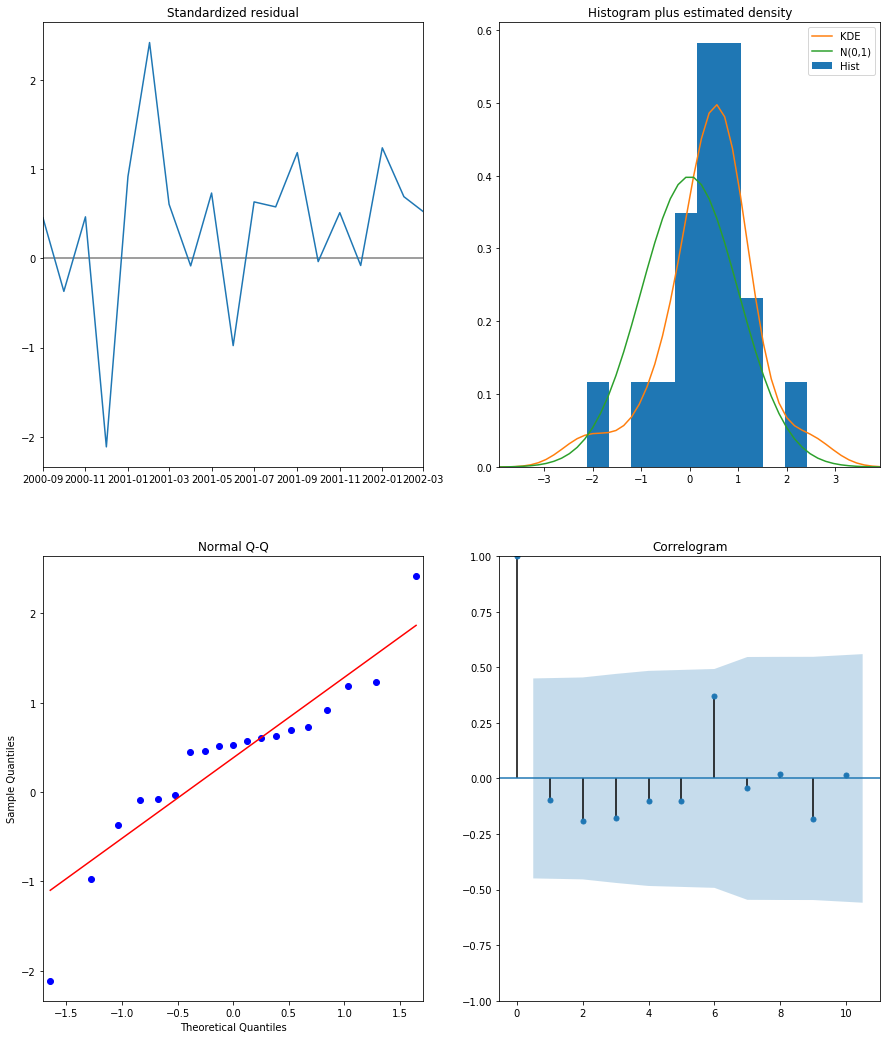

In [162]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(average_ts.iloc[0:72], 
                                        order=(2, 3, 1), 
                                        seasonal_order=(2, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()
print(output.summary().tables[1])
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [41]:
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(average_ts.iloc[0:84],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2213.899062453415
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1860.289857992121
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =1648.5142226008486
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1527.9155891714981
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1281.0661253682779
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =1089.0299623813548
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =845.5870545501257
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1333.2873099407166
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1327.8131619977323
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1545.7887323608534
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1082.357863531542
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1065.7828765458355
ARIMA (0, 0, 0) x (1, 2, 0, 12)12 : AIC Calculated =856.529328697773
ARIMA (0, 0, 0) x (1, 2, 1, 12)12 : AIC Calculated =838.6276752731904
ARIMA (0, 0, 

ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =545.5212006631656
ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =530.8834577728512
ARIMA (0, 1, 2) x (2, 0, 0, 12)12 : AIC Calculated =782.7077109131524
ARIMA (0, 1, 2) x (2, 0, 1, 12)12 : AIC Calculated =830.3843495366351
ARIMA (0, 1, 2) x (2, 0, 2, 12)12 : AIC Calculated =4449.232351943276
ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =596.3311351208001
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =603.0637755017391
ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =422.85042782195274
ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =493.3097445212483
ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =899.0334855654181
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =772.184702154747
ARIMA (0, 2, 0) x (0, 0, 2, 12)12 : AIC Calculated =2243.805745260706
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =740.7706619217698
ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =621.0631638044107
ARIMA (0, 2, 0) x (0

ARIMA (1, 0, 2) x (0, 1, 1, 12)12 : AIC Calculated =672.3569071853573
ARIMA (1, 0, 2) x (0, 2, 0, 12)12 : AIC Calculated =728.7328628816664
ARIMA (1, 0, 2) x (0, 2, 1, 12)12 : AIC Calculated =561.8952956650432
ARIMA (1, 0, 2) x (1, 0, 0, 12)12 : AIC Calculated =895.277808762785
ARIMA (1, 0, 2) x (1, 0, 1, 12)12 : AIC Calculated =937.7857694076142
ARIMA (1, 0, 2) x (1, 0, 2, 12)12 : AIC Calculated =4102.198579638503
ARIMA (1, 0, 2) x (1, 1, 0, 12)12 : AIC Calculated =764.2963127445237
ARIMA (1, 0, 2) x (1, 1, 1, 12)12 : AIC Calculated =785.3485264364436
ARIMA (1, 0, 2) x (1, 2, 0, 12)12 : AIC Calculated =567.9763903782559
ARIMA (1, 0, 2) x (1, 2, 1, 12)12 : AIC Calculated =621.116374461929
ARIMA (1, 0, 2) x (2, 0, 0, 12)12 : AIC Calculated =743.337279538641
ARIMA (1, 0, 2) x (2, 0, 1, 12)12 : AIC Calculated =1002.7076743606113
ARIMA (1, 0, 2) x (2, 0, 2, 12)12 : AIC Calculated =3590.410371962902
ARIMA (1, 0, 2) x (2, 1, 0, 12)12 : AIC Calculated =572.2795539177168
ARIMA (1, 0, 2) x (2, 

ARIMA (1, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =2005.6776401363818
ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =491.64541913031064
ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =493.5400071263539
ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =376.38945059361197
ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =378.09656597944877
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =831.1432772752714
ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =711.2687284726321
ARIMA (1, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =2360.154260015311
ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =686.1804934438132
ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =586.4558595879025
ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =586.8335517877099
ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =465.78579136357797
ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =710.6665011868844
ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =685.8966223779751
ARIMA (1, 2, 2)

ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =735.7717302213385
ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =737.7117400752662
ARIMA (2, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4227.055886785655
ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =610.9567162850501
ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =612.8445588661028
ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =495.3424129483666
ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =512.8423930134256
ARIMA (2, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =604.305584767609
ARIMA (2, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =607.1772398382102
ARIMA (2, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4012.167160248329
ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =497.4636374071205
ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =503.42789821271833
ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =377.92353478260316
ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =379.5557226118352
ARIMA (2, 1, 2) x (

In [72]:
aic = np.zeros(len(ans))
for i,a in enumerate(ans):
    aic[i] = a[2]
for i in range(10):
    print(ans[np.argsort(aic)[i]])

[(2, 2, 0), (2, 2, 0, 12), 348.30812607466123]
[(2, 2, 0), (2, 2, 1, 12), 348.51126946351394]
[(2, 2, 1), (2, 2, 0, 12), 348.8652648815048]
[(2, 2, 1), (2, 2, 1, 12), 349.6591351052493]
[(2, 2, 2), (2, 2, 0, 12), 350.29306533399756]
[(2, 2, 2), (2, 2, 1, 12), 351.0733684943043]
[(2, 1, 2), (2, 2, 0, 12), 372.6805304864755]
[(1, 2, 2), (2, 2, 0, 12), 376.12675123980114]
[(1, 2, 1), (2, 2, 0, 12), 376.38945059361197]
[(1, 2, 2), (2, 2, 1, 12), 377.3846366596228]


In [38]:
p = d = q = range(1, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(average_ts.iloc[-85:-1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =730.9935944563737
ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =611.0213985237996
ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =590.4370902348087
ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =457.92411816423015
ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =719.1322455725449
ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =595.0391724557871
ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =594.547283564836
ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =446.6506701568154
ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =723.2383185371798
ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =596.771898350596
ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =579.1297426400353
ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =444.9658939926064
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =703.4025647284398
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =574.7519260985908
ARIMA (1, 2, 2) x (2,

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5744      0.563      1.020      0.308      -0.530       1.678
ar.L2          0.0218      0.461      0.047      0.962      -0.881       0.925
ma.L1         -0.9561      0.820     -1.166      0.243      -2.563       0.650
ar.S.L12      -0.2923      0.518     -0.565      0.572      -1.307       0.722
ar.S.L24       0.0318      0.111      0.288      0.774      -0.185       0.249
ma.S.L12      -0.0513      1.033     -0.050      0.960      -2.076       1.973
sigma2      4.237e+04   1.77e+04      2.392      0.017    7647.259    7.71e+04


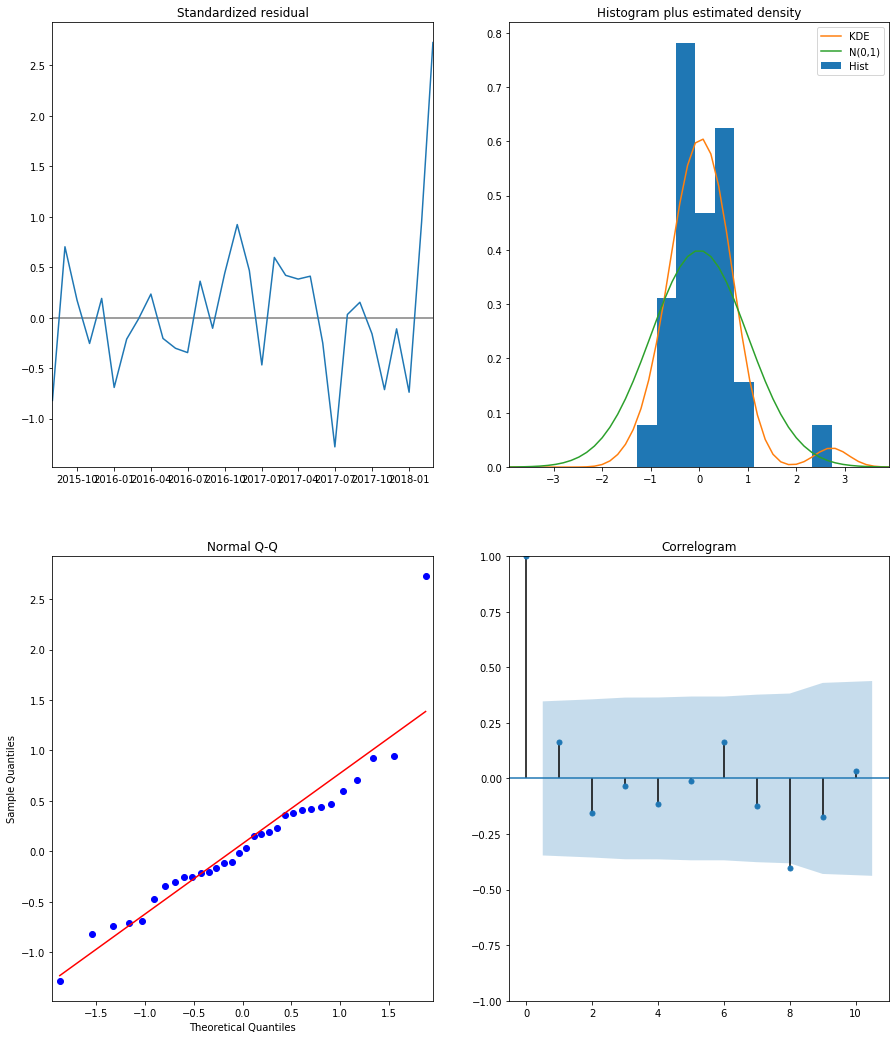

In [39]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(average_ts.iloc[-85:-1], 
                                        order=(2, 2, 1), 
                                        seasonal_order=(2, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [95]:
p = d = q = range(0, 2)
d = [3]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(average_ts[-85:-1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 3, 0) x (0, 3, 0, 12)12 : AIC Calculated =861.9604511740974
ARIMA (0, 3, 0) x (0, 3, 1, 12)12 : AIC Calculated =1233.2504485371796
ARIMA (0, 3, 0) x (1, 3, 0, 12)12 : AIC Calculated =502.88944608356474
ARIMA (0, 3, 0) x (1, 3, 1, 12)12 : AIC Calculated =1282.7065799235424
ARIMA (0, 3, 1) x (0, 3, 0, 12)12 : AIC Calculated =856.3854069762315
ARIMA (0, 3, 1) x (0, 3, 1, 12)12 : AIC Calculated =1198.0550889557678
ARIMA (0, 3, 1) x (1, 3, 0, 12)12 : AIC Calculated =492.2332954323279
ARIMA (0, 3, 1) x (1, 3, 1, 12)12 : AIC Calculated =1154.891613080849
ARIMA (1, 3, 0) x (0, 3, 0, 12)12 : AIC Calculated =863.9323880031674
ARIMA (1, 3, 0) x (0, 3, 1, 12)12 : AIC Calculated =999.1332592565111
ARIMA (1, 3, 0) x (1, 3, 0, 12)12 : AIC Calculated =480.92427415458997
ARIMA (1, 3, 0) x (1, 3, 1, 12)12 : AIC Calculated =1248.8598470635548
ARIMA (1, 3, 1) x (0, 3, 0, 12)12 : AIC Calculated =816.0628570416089
ARIMA (1, 3, 1) x (0, 3, 1, 12)12 : AIC Calculated =1207.37002867752
ARIMA (1, 3, 1)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8915      0.046     19.356      0.000       0.801       0.982
ma.L1         -0.9357      0.055    -16.961      0.000      -1.044      -0.828
ar.S.L12      -0.5769      0.119     -4.852      0.000      -0.810      -0.344
sigma2      2.719e+04   4341.071      6.264      0.000    1.87e+04    3.57e+04


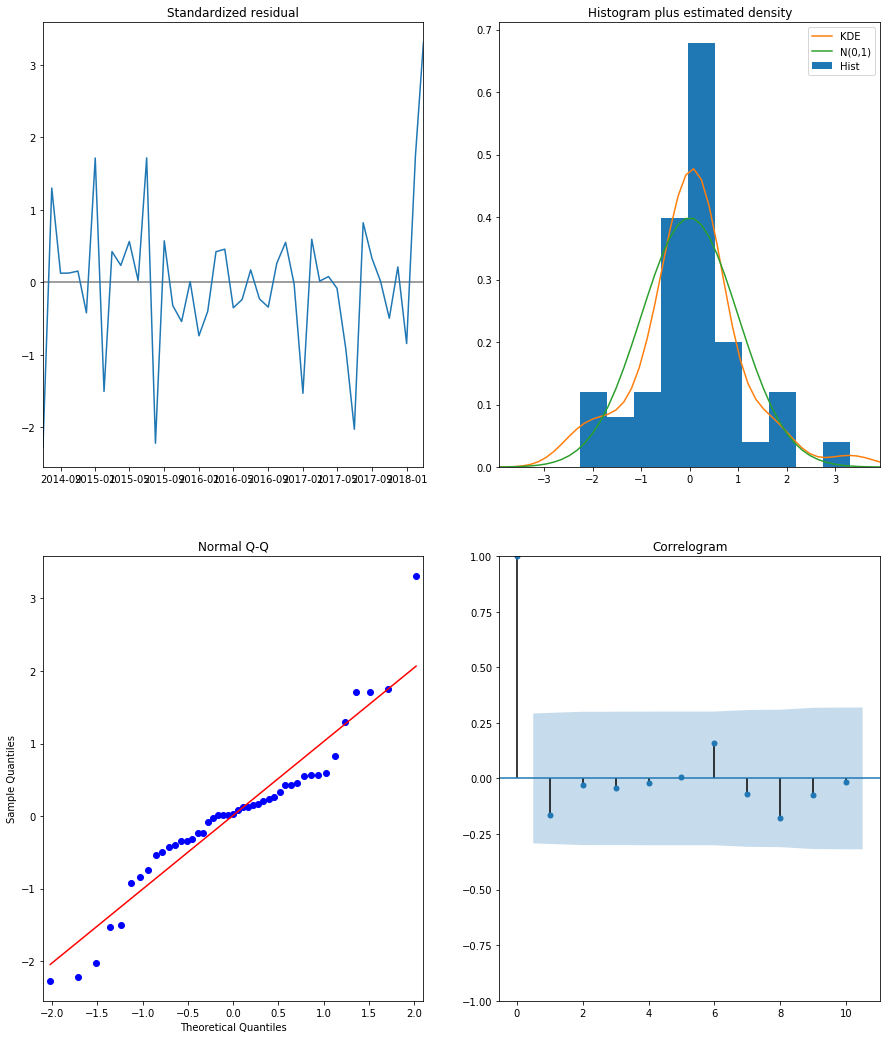

In [97]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(average_ts.iloc[-85:-1], 
                                        order=(1, 2, 1), 
                                        seasonal_order=(1, 2, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [183]:
average_ts_begin = average_ts[0:72].diff(12).dropna()
average_diff_2 = average_ts_begin -2*average_ts_begin.shift()+average_ts_begin.shift(2)
average_diff_3 = average_ts_begin -3*average_ts_begin.shift()+3*average_ts_begin.shift(2)-average_ts_begin.shift(3)
average_diff_4 = average_ts_begin -4*average_ts_begin.shift()+6*average_ts_begin.shift(2)-4*average_ts_begin.shift(3)+average_ts_begin.shift(4)

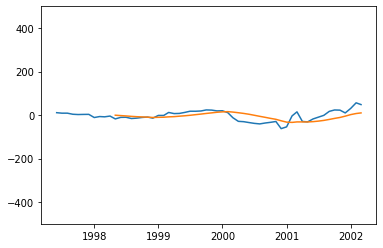

In [184]:
plt.plot(average_diff_2)
plt.ylim(-500,500)
plt.plot(average_diff_2.rolling(window=12).mean())

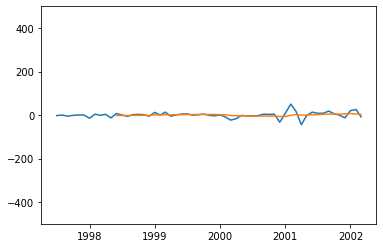

In [185]:
plt.plot(average_diff_3)
plt.ylim(-500,500)
plt.plot(average_diff_3.rolling(window=12).mean())

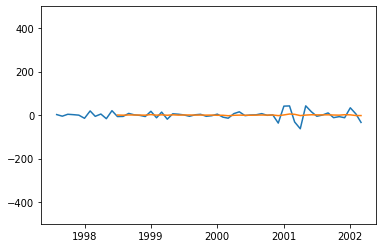

In [186]:
plt.plot(average_diff_4)
plt.ylim(-500,500)
plt.plot(average_diff_4.rolling(window=12).mean())

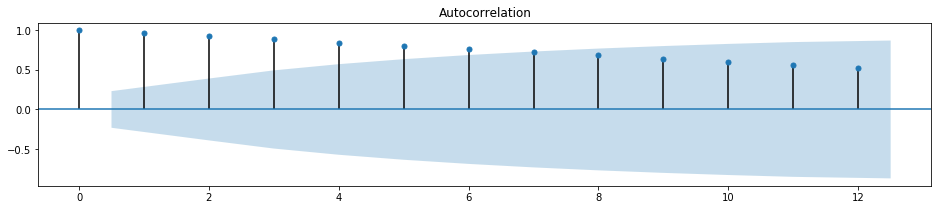

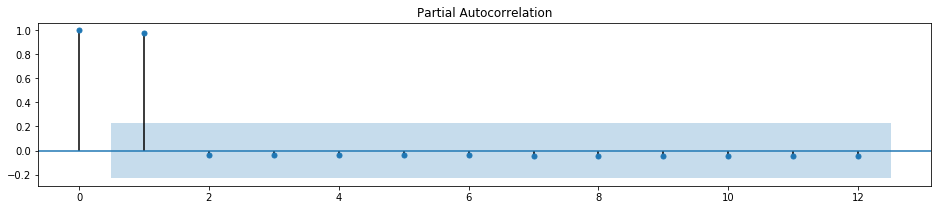

In [156]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(average_ts_begin,ax=ax, lags=12);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(average_ts_begin,ax=ax, lags=12);

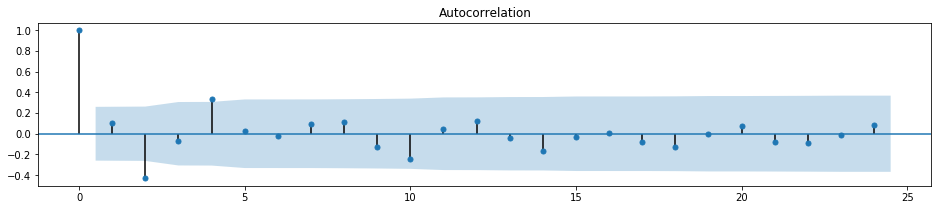

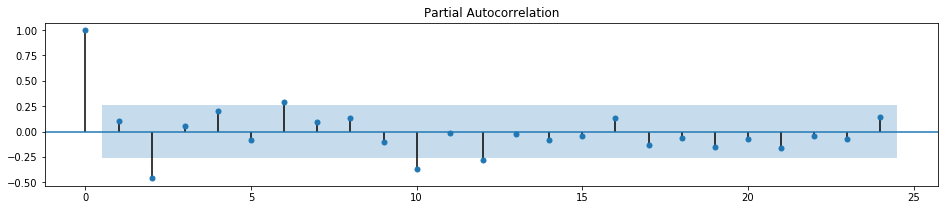

In [187]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(average_diff_3.dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(average_diff_3.dropna(),ax=ax, lags=24);

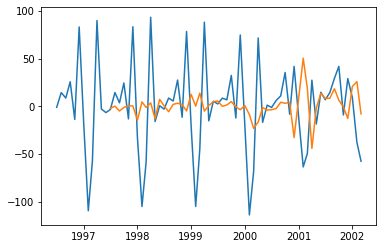

In [164]:
plt.plot(average_diff_3)
plt.plot(average_diff_3.diff(12))

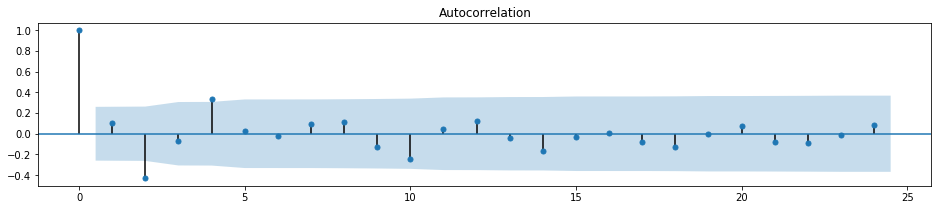

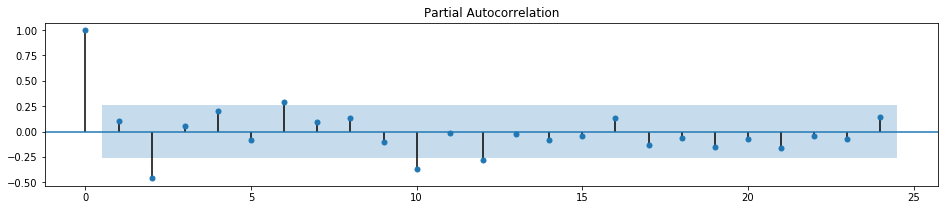

In [165]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(average_diff_3.diff(12).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(average_diff_3.diff(12).dropna(),ax=ax, lags=24);

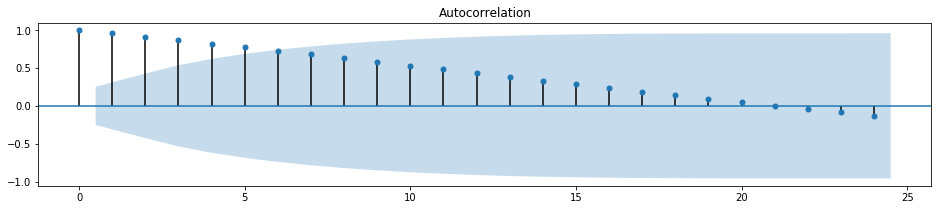

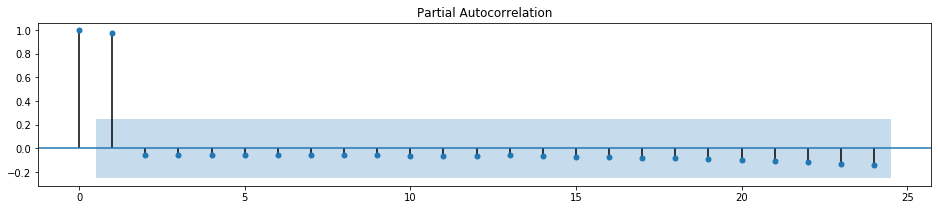

In [172]:

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(average_ts[0:72].diff(12).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(average_ts[0:72].diff(12).dropna(),ax=ax, lags=24);

In [196]:
# Fit an AR(1) model to the first simulated data
mod_arma = ARMA(average_diff_3.dropna(), order=(2,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   57
Model:                     ARMA(2, 0)   Log Likelihood                -221.121
Method:                       css-mle   S.D. of innovations             11.658
Date:                Tue, 28 Jan 2020   AIC                            450.242
Time:                        23:41:48   BIC                            458.414
Sample:                    07-01-1997   HQIC                           453.418
                         - 03-01-2002                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5466      1.191      0.459      0.648      -1.787       2.880
ar.L1.value     0.1563      0.118      1.329      0.190      -0.074       0.387
ar.L2.value    -0.4673      0.119     -3.940    

# Step 6: Interpreting Results